## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, fbeta_score

from skopt import BayesSearchCV

import shap

import warnings
warnings.filterwarnings("ignore")

## Read Dataset

In [2]:
data = pd.read_csv("data/Heart_Disease_Kaggle_Preprocessed.csv")
print(data.shape)
data.head()

(268, 14)


,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,ECG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,1.733026,0.681528,0.871534,-0.064103,1.407389,-0.418854,0.977857,-1.777056,-0.699206,1.193857,0.680101,2.462874,-0.881493,1
1,1.400801,-1.467290,-0.180588,-0.914581,6.109512,-0.418854,0.977857,0.437459,-0.699206,0.491048,0.680101,-0.715538,1.181740,0
2,0.293383,0.681528,-1.232710,-0.404294,0.222143,-0.418854,-1.022644,-0.387556,-0.699206,-0.651016,-0.947283,-0.715538,1.181740,1
3,1.068576,0.681528,0.871534,-0.177500,0.261004,-0.418854,-1.022644,-1.950743,1.430194,-0.738867,0.680101,0.343933,1.181740,0
4,2.175994,-1.467290,-1.232710,-0.631088,0.377585,-0.418854,0.977857,-1.255994,1.430194,-0.738867,-0.947283,0.343933,-0.881493,0


## Data split

In [3]:
X = data.drop(columns=["Heart Disease"])
y = data["Heart Disease"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Metrics settings

In [4]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fbeta_scorer = make_scorer(fbeta_score, beta=2)

scoring_metrics = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "fbeta_2": fbeta_scorer,
    "roc_auc": "roc_auc"
}

## Cross-validation

In [5]:
xgb = XGBClassifier() 
scores_xgb = cross_validate(xgb, X, y, cv=cv, scoring=scoring_metrics)

print("Scores XGBoost:")
for metric in scoring_metrics:
    mean_score = np.mean(scores_xgb[f"test_{metric}"])
    std_score = np.std(scores_xgb[f"test_{metric}"])
    print(f"{metric.capitalize()}: {mean_score:.4f} ± {std_score:.4f}")


Scores XGBoost:
Accuracy: 0.8283 ± 0.0690
Precision: 0.8398 ± 0.0974
Recall: 0.7739 ± 0.1158
Fbeta_2: 0.7823 ± 0.0978
Roc_auc: 0.8920 ± 0.0520


## Bayesian Optimization

In [6]:
search_space = {
    'n_estimators': (10, 500),  # Number of trees
    'max_depth': (1, 50),  # Maximum depth of each tree
    'learning_rate': (0.001, 0.1, 'uniform'),  # Learning rate
    'subsample': (0.5, 1.0),  # Subsample ratio of the training data
    'colsample_bytree': (0.5, 1.0),  # Subsample ratio of features
    'gamma': (0, 5),  # Regularization parameter
    'min_child_weight': (1, 20)  # Minimum sum of instance weight (hessian) needed in a child
}

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up Bayesian Optimization for XGBoost
opt_xgb = BayesSearchCV(
    XGBClassifier(random_state=42),
    search_spaces=search_space,
    scoring="roc_auc",  # Use ROC AUC directly
    cv=cv,
    n_iter=30,  # Number of iterations for the search
    n_jobs=-1,  # Use all available CPUs
    random_state=42
)

# Fit the model
opt_xgb.fit(X, y)

best_params = opt_xgb.best_params_

# Print the best parameters and the best ROC-AUC score
print("Best parameters:", best_params)
print("Best ROC AUC score (cv):", opt_xgb.best_score_)

Best parameters: OrderedDict([('colsample_bytree', 0.5030303068830654), ('gamma', 1), ('learning_rate', 0.08196684430569222), ('max_depth', 6), ('min_child_weight', 6), ('n_estimators', 208), ('subsample', 0.8818618831470533)])
Best ROC AUC score (cv): 0.9168215892053974


## Cross-validation with best model

In [7]:
xgb = XGBClassifier(**best_params) 
scores_xgb = cross_validate(xgb, X, y, cv=cv, scoring=scoring_metrics)

print("Scores XGBoost:")
for metric in scoring_metrics:
    mean_score = np.mean(scores_xgb[f"test_{metric}"])
    std_score = np.std(scores_xgb[f"test_{metric}"])
    print(f"{metric.capitalize()}: {mean_score:.4f} ± {std_score:.4f}")


Scores XGBoost:
Accuracy: 0.8509 ± 0.0554
Precision: 0.8500 ± 0.0745
Recall: 0.8159 ± 0.0850
Fbeta_2: 0.8205 ± 0.0741
Roc_auc: 0.9202 ± 0.0579


## Feature Importance | SHAP

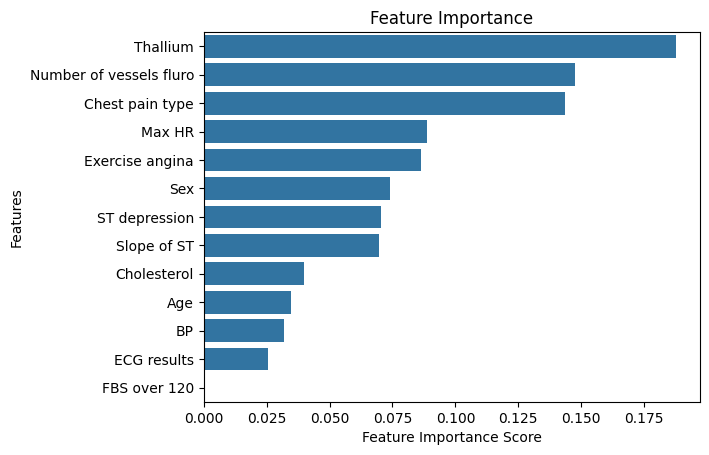

In [8]:
xgb.fit(X_train, y_train)

feature_importance = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plotting Feature Importance
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()

1.66893e-06


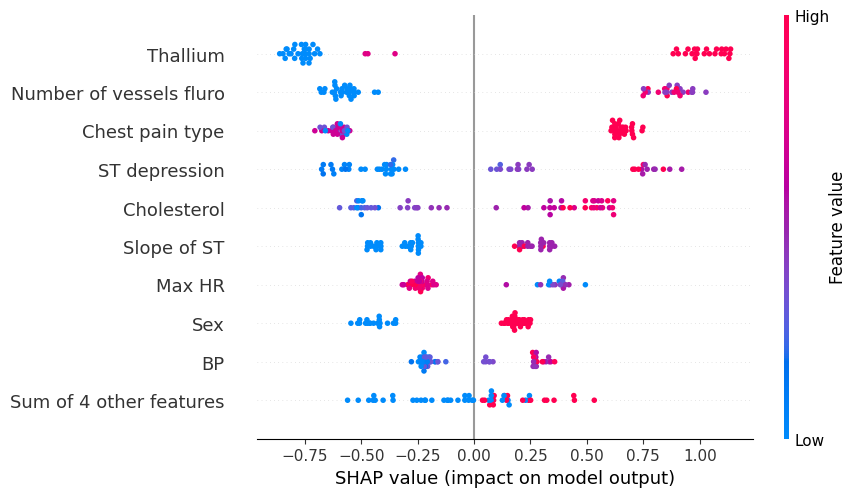

In [11]:
pred = xgb.predict(X_test, output_margin=True)

explainer = shap.TreeExplainer(xgb)
explanation = explainer(X_test)

shap_values = explanation.values

# make sure the SHAP values add up to marginal predictions
print(np.abs(shap_values.sum(axis=1) + explanation.base_values - pred).max())

shap.plots.beeswarm(explanation)